 ### First, import all libraries that used in this project

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [2]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("../input"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


## Step 1. Data analysis and preprocessing

In [3]:
data_dir = '../input'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [5]:
# norm_mean,norm_std = compute_img_mean_std(all_image_path)


In [6]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [7]:
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [8]:
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [9]:
df_original['duplicates'].value_counts()


duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [10]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [11]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [12]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: count, dtype: int64

In [13]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [14]:
df_train['cell_type_idx'].value_counts()

cell_type_idx
4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: count, dtype: int64

In [15]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: count, dtype: int64

In [16]:
data_aug_rate = [29, 25, 10, 110, 0, 67, 19]

# Liste pour stocker les DataFrames à concaténer
dataframes = [df_val]

for i in range(7):
    if data_aug_rate[i]:
        # Créer des copies des données de la classe actuelle
        repeated_data = [df_val[df_val['cell_type_idx'] == i]] * (data_aug_rate[i] - 1)
        # Ajouter à la liste
        dataframes.append(pd.concat(repeated_data, ignore_index=True))

# Concaténer tous les DataFrames
df_val1 = pd.concat(dataframes, ignore_index=True)

# Vérifier les nouvelles distributions
print(df_val1['cell_type'].value_counts())


cell_type
Melanocytic nevi                  883
Dermatofibroma                    880
Benign keratosis-like lesions     880
Basal cell carcinoma              875
dermatofibroma                    874
Vascular lesions                  871
Actinic keratoses                 870
Name: count, dtype: int64


In [17]:
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

# Liste pour stocker les DataFrames à concaténer
dataframes = [df_train]

for i in range(7):
    if data_aug_rate[i]:
        # Créer des copies des données de la classe actuelle
        repeated_data = [df_train[df_train['cell_type_idx'] == i]] * (data_aug_rate[i] - 1)
        # Ajouter à la liste
        dataframes.append(pd.concat(repeated_data, ignore_index=True))

# Concaténer tous les DataFrames
df_train = pd.concat(dataframes, ignore_index=True)

# Vérifier les nouvelles distributions
print(df_train['cell_type'].value_counts())


cell_type
Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: count, dtype: int64


In [18]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

In [19]:
df_train.shape

(35967, 13)

In [20]:
df_train.shape

(35967, 13)

## Step 2. Model building

In [21]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "efficientnet":
        """ EfficientNet-B0 """
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [23]:
# EfficientNet
model_name = 'densenet'
num_classes = 7
feature_extract = False

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Define the device:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Put the model on the device:
model = model_ft.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 210MB/s]


In [24]:
 norm_mean = (0.49139968, 0.48215827, 0.44653124)
 norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [25]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [26]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
validation_set1 = HAM10000(df_val1, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)
val_loader1 = DataLoader(validation_set1, batch_size=32, shuffle=False, num_workers=4)

In [27]:
for i, data in enumerate(train_loader):
    images, labels = data
    N = images.size(0)
    images = Variable(images).to(device)
    labels = Variable(labels).to(device)
    print(labels)
    break

tensor([5, 5, 5, 6, 6, 1, 1, 3, 6, 6, 2, 1, 3, 6, 0, 3, 5, 6, 2, 3, 2, 1, 5, 1,
        5, 0, 4, 0, 4, 3, 0, 4], device='cuda:0')


In [28]:
import torch

# Afficher la version de PyTorch
print("Version de PyTorch :", torch.__version__)

# Vérifier la version de CUDA utilisée par PyTorch (si disponible)
if torch.cuda.is_available():
    print("Version de CUDA supportée :", torch.version.cuda)
else:
    print("CUDA n'est pas disponible.")


Version de PyTorch : 2.4.1+cu121
Version de CUDA supportée : 12.1


In [29]:
# Utilisation de SGD comme optimiseur
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Implémentation de la Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # pt is the probability of the true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Utilisation de Focal Loss comme fonction de perte
criterion = FocalLoss(gamma=2.0, alpha=1.0).to(device)


## Step 3. Model training

In [30]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [32]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    all_labels = []  # Liste pour stocker les étiquettes réelles
    all_preds = []   # Liste pour stocker les scores des prédictions

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)
            val_loss.update(criterion(outputs, labels).item())

            # Stocker les étiquettes réelles et les scores des prédictions
            all_labels.extend(labels.cpu().numpy())  # Ajouter les étiquettes
            all_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Ajouter les probabilités

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg, np.array(all_labels), np.array(all_preds)


In [33]:
# Initialiser les listes pour stocker les métriques
total_loss_train = []  # Pertes d'entraînement
total_acc_train = []   # Précisions d'entraînement
total_loss_val = []    # Pertes de validation
total_acc_val = []     # Précisions de validation
best_val_acc = 0  # Meilleure précision de validation
epoch_num = 20  # Nombre d'époques

# Initialiser des listes pour stocker toutes les étiquettes et probabilités de validation
all_labels_total = []
all_preds_total = []

for epoch in range(1, epoch_num + 1):
    # Entraînement
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    
    # Validation
    loss_val, acc_val, all_labels, all_preds = validate(val_loader, model, criterion, optimizer, epoch)
    
    # Stocker les métriques
    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    
    # Stocker les étiquettes et probabilités de validation pour toutes les époques
    all_labels_total.extend(all_labels)
    all_preds_total.extend(all_preds)
    
    # Vérifier si c'est la meilleure précision de validation
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')



[epoch 1], [iter 100 / 1124], [train loss 0.90667], [train acc 0.47187]
[epoch 1], [iter 200 / 1124], [train loss 0.69040], [train acc 0.57531]
[epoch 1], [iter 300 / 1124], [train loss 0.59112], [train acc 0.62271]
[epoch 1], [iter 400 / 1124], [train loss 0.52512], [train acc 0.65766]
[epoch 1], [iter 500 / 1124], [train loss 0.48181], [train acc 0.68094]
[epoch 1], [iter 600 / 1124], [train loss 0.44764], [train acc 0.69911]
[epoch 1], [iter 700 / 1124], [train loss 0.42006], [train acc 0.71362]
[epoch 1], [iter 800 / 1124], [train loss 0.39831], [train acc 0.72492]
[epoch 1], [iter 900 / 1124], [train loss 0.37770], [train acc 0.73618]
[epoch 1], [iter 1000 / 1124], [train loss 0.36127], [train acc 0.74494]
[epoch 1], [iter 1100 / 1124], [train loss 0.34728], [train acc 0.75261]
------------------------------------------------------------
[epoch 1], [val loss 0.16540], [val acc 0.87667]
------------------------------------------------------------
***********************************

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def plot_roc_multiclass(y_true, y_scores, num_classes):

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'yellow'])
    
    for i, color in zip(range(num_classes), colors):
        # Calculer les courbes ROC
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        # Tracer la courbe ROC pour la classe i
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonale
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=14)
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=14)
    plt.title('Courbes ROC Multiclasse', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()



=== Courbes ROC après toutes les époques ===


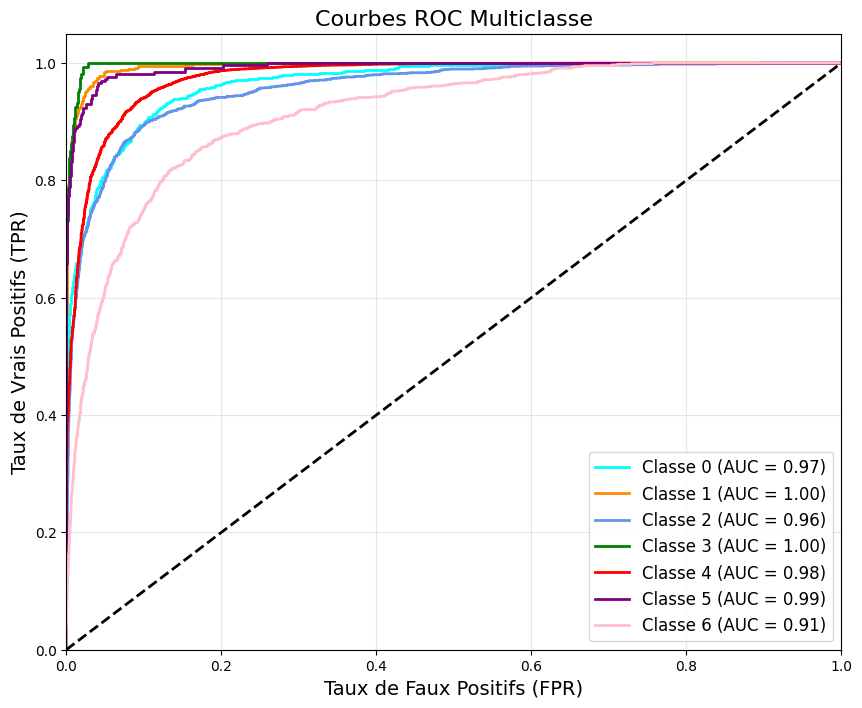

In [35]:
# Tracer la courbe ROC après toutes les époques
print("\n=== Courbes ROC après toutes les époques ===")
all_labels_total = np.array(all_labels_total)
all_preds_total = np.array(all_preds_total)
plot_roc_multiclass(all_labels_total, all_preds_total, 7)


In [36]:
# Average training metrics per epoch
epoch_train_loss = []
epoch_train_acc = []

num_iters_per_epoch = len(total_loss_train) // len(total_loss_val)
for i in range(len(total_loss_val)):
    start = i * num_iters_per_epoch
    end = (i + 1) * num_iters_per_epoch
    epoch_train_loss.append(sum(total_loss_train[start:end]) / num_iters_per_epoch)
    epoch_train_acc.append(sum(total_acc_train[start:end]) / num_iters_per_epoch)

# Now all lists have the same length
results = pd.DataFrame({
    'epoch': list(range(1, len(total_loss_val) + 1)),
    'train_loss': epoch_train_loss,
    'train_acc': epoch_train_acc,
    'val_loss': total_loss_val,
    'val_acc': total_acc_val
})

# Save to CSV
results.to_csv('training_resultsex2.csv', index=False)
print("Training results saved successfully!")


Training results saved successfully!


In [37]:
results

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.490889,0.677897,0.165401,0.876667
1,2,0.156119,0.867565,0.154748,0.880119
2,3,0.103893,0.903223,0.144708,0.897202
3,4,0.071714,0.929762,0.154641,0.907917
4,5,0.055577,0.942462,0.148730,0.895298
5,6,0.043720,0.954536,0.156455,0.908810
6,7,0.036560,0.962445,0.164143,0.904226
7,8,0.030741,0.967324,0.152351,0.923988
8,9,0.022794,0.975417,0.171176,0.905238
9,10,0.021697,0.976734,0.159717,0.907798


In [38]:
torch.save(model.state_dict(), 'best_model.pth')
print("Meilleur modèle enregistré sous 'best_model.pth'")

Meilleur modèle enregistré sous 'best_model.pth'


## Step 4. Model evaluation

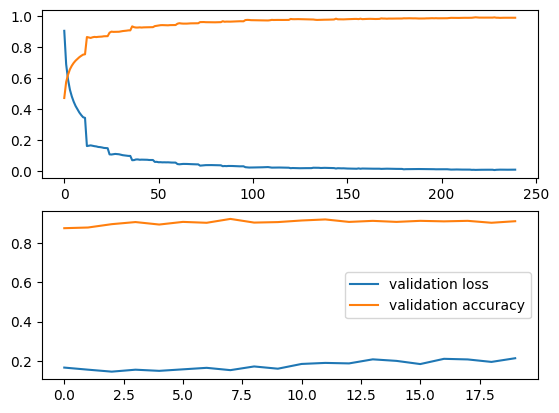

In [39]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

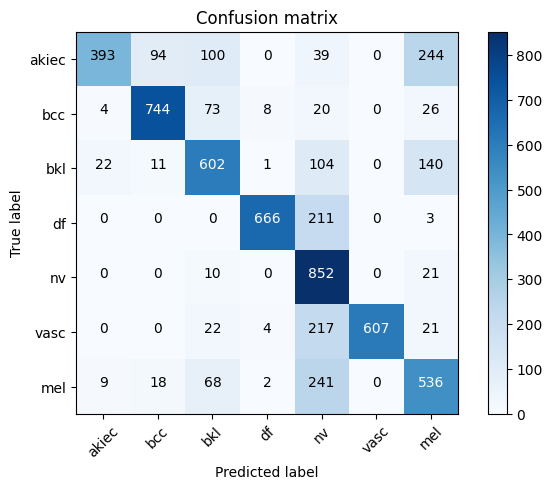

In [41]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader1):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [42]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.92      0.45      0.61       870
         bcc       0.86      0.85      0.85       875
         bkl       0.69      0.68      0.69       880
          df       0.98      0.76      0.85       880
          nv       0.51      0.96      0.66       883
        vasc       1.00      0.70      0.82       871
         mel       0.54      0.61      0.57       874

    accuracy                           0.72      6133
   macro avg       0.78      0.72      0.72      6133
weighted avg       0.78      0.72      0.72      6133



Text(0, 0.5, 'Fraction classified incorrectly')

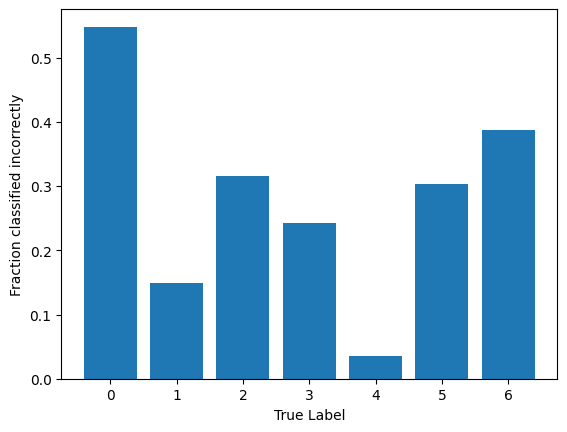

In [43]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')